In [2]:
import re
from collections import Counter

import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.sparse as sps
import sklearn.svm as sksvm
import sklearn.linear_model as sklin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline

# Linear SVM

### Intuition
For a group of data with two classes, consider a hyperplane, which separate the two classes "as much as possible";

"as much as possible":
* Separable case: maximize the margin between the two classes
* nonseparable case: control (minimize) the amount and magnitude of cross-border points

### Mathematical form:
hyperplane -- $\beta_0 + u^\top\beta = 0$; distance from a point $x$ to this hyperplane: $\frac{|\beta_0 + x^\top\beta|}{\|\beta\|_2}$
* Separable case:  
    $$ \text{maximize}\;\;\; M,\;\;\; \text{such that}\;\;\; \frac{|\beta_0 + x_i^\top\beta|}{\|\beta\|_2} \geq M,\;\;\; i = 1, \ldots, n $$
    if $y_i = \pm 1$, then we can enforce
    $$ \text{maximize}\;\;\; M,\;\;\; \text{such that}\;\;\; y_i(\beta_0 + x_i^\top\beta) \geq M \|\beta\|_2,\;\;\; i = 1, \ldots, n $$
    $\|\beta\|_2$ is the "unit-length" of your ruler, so you can always rescale the unit-length of your ruler, such that the "projected distance" $y_i(x_i^\top\beta + \beta_0) \geq 1$, but then the smaller your unit is, the longer the true distance is. As a result, we have
    $$ \text{minimize}\;\;\; \|\beta\|_2^2,\;\;\; \text{such that}\;\;\; y_i(\beta_0 + x_i^\top\beta) \geq 1,\;\;\; i = 1, \ldots, n $$
    * Primal form
        $$ \text{minimize}\;\;\; \frac{1}{2}\|\beta\|_2^2,\;\;\; \text{such that}\;\;\; y_i(\beta_0 + x_i^\top\beta) \geq 1,\;\;\; i = 1, \ldots, n$$
    * Dual form
        $$ \text{minimize}\;\;\; \frac{1}{2}\sum_{i, j} \alpha_i\alpha_j y_iy_j\langle x_i, x_j \rangle - \sum_i \alpha_i ,\;\;\; \text{such that}\;\;\; \alpha_i \geq 0,\;\;\; i = 1, \ldots, n, \sum_i \alpha_i y_i = 0 $$
    where $\langle x_i, x_j \rangle = x_i^\top x_j$
    * KKT condition: necessary condition for optimality. 1 stationary condition, 2 feasibility condition, 1 complementary slackness
        * stationary: $\beta = \sum_i \alpha_i y_i x_i$, $0=\sum_i \alpha_i y_i$, $i=1, \ldots, n$;
        * primal feasibility: $y_i(\beta_0 + x_i^\top\beta) \geq 1)$;
        * dual feasibility: $\alpha_i \geq 0$;
        * complementary slackness: $\alpha_i(1 - y_i(\beta_0 + x_i^\top\beta)) = 0$;
    * $i$ such that $\alpha_i > 0$ are support vectors;

* Non-separable case: allow cross boundary points, but control the extent they cross boundary
    *  First form
        $$ \text{minimize}\;\;\; \frac{1}{2}\|\beta\|_2^2,\;\;\; \text{such that}\;\;\; y_i(\beta_0 + x_i^\top\beta) \geq 1 - \xi_i,\;\; \xi_i \geq 0,\;\; i = 1, \ldots, n,\;\;\; \sum_i \xi_i \leq A $$
    * Primal form
        $$ \text{minimize}\;\;\; \frac{1}{2}\|\beta\|_2^2 + C\sum_i \xi_i,\;\;\; \text{such that}\;\;\; y_i(\beta_0 + x_i^\top\beta) \geq 1 - \xi_i,\;\; \xi_i \geq 0,\;\; i = 1, \ldots, n $$
    * Dual form
        $$ \text{minimize}\;\;\; \frac{1}{2}\sum_{i, j} \alpha_i\alpha_j y_iy_j\langle x_i, x_j \rangle - \sum_i \alpha_i ,\;\;\; \text{such that}\;\;\; 0 \leq \alpha_i \leq C,\;\;\; i = 1, \ldots, n, \sum_i \alpha_i y_i = 0 $$
    where $\langle x_i, x_j \rangle = x_i^\top x_j$
    * KKT condition: necessary condition for optimality. 1 stationary condition, 2 feasibility condition, 1 complementary slackness
        * stationary: $\beta = \sum_i \alpha_i y_i x_i$, $0=\sum_i \alpha_i y_i$, $C = \alpha_i + \mu_i$, $i=1, \ldots, n$;
        * primal feasibility: $y_i(\beta_0 + x_i^\top\beta) \geq 1 - \xi_i)$, $\xi_i \geq 0$;
        * dual feasibility: $C \geq \alpha_i \geq 0$, $\mu_i \geq 0$;
        * complementary slackness: $\alpha_i(1 - \xi_i - y_i(\beta_0 + x_i^\top\beta)) = 0$, $\sum_i \mu_i\xi_i = 0$
    * $i$ such that $\alpha_i > 0$ are support vectors; $0 < \alpha_i < C$ stay on the boundary; $\alpha_i = C$ cross boundary;


# Real Data Example of Linear SVM

## Kaggle --- Toxic Comment Classification Challenge

Feel free to go over the preprocessing step

One of the step where each sentence is transformed to a 0-1 vector marking whether a word is contained in the sentence takes a long time (around 30 mins), so I write the data to a file called `X_data.npz`.

Please directly load the `X_data.npz` during the tutorial session.

### About the data
The data is a collection of comments from Wikipedia. 6 categories can be potentially labelled to them: toxic, severe-toxic, insult, obscene, threat, identity_hate; Each sentence can have multiple labels, or none of them;

Original task: label the data

Our simplified task: as long as a sentence contains one of the labels, it is a "bad" sentence; otherwise it is a good one;

In [3]:
# please change datapath to your own data path
datapath = "/home/wangsw09/work/TA/GR5241_statistical_machine_learning/Week_4_SVM/"
dataname = "train.csv"

Load in the data

In [4]:
data = pd.read_csv(datapath + dataname)

In [10]:
n = data.shape[0]

Construct the vector of responses y and covariate matrix X

In [12]:
X_raw = data["comment_text"]
y_raw = data.loc[:,"toxic" : "identity_hate"]

Mark a row as 1 if any of the labels are assigned to this row

In [13]:
y = y_raw.any(axis=1) * 2 - 1
y = y.values

Extract X, a 0-1 vector of words

In [14]:
split_s = re.compile(r"[a-z]+", re.IGNORECASE)

In [15]:
X_raw1 = X_raw.apply(lambda s: split_s.findall(s.lower()))

Construct a Counter object to store words and their counts; remove the words with counts smaller than or equal to 10

In [16]:
word_dict = Counter()
for i in xrange(n):
    word_dict.update(X_raw1[i])

print len(word_dict)

for k in word_dict.keys():
    if word_dict[k] <= 10:
        del word_dict[k]

print len(word_dict)

168816
24735


Construct a stop_list for the those noninformative words, such as "you", "I"; We manully select these words from the most frequent 150 words

In [17]:
stop_list = [tup[0] for tup in word_dict.most_common(150)]

In [18]:
print stop_list

['the', 'to', 'i', 'of', 'and', 'you', 'a', 'is', 'that', 'it', 'in', 'for', 'this', 'not', 'on', 'be', 'as', 's', 'have', 'are', 'your', 't', 'with', 'if', 'article', 'was', 'or', 'but', 'wikipedia', 'page', 'my', 'an', 'from', 'by', 'do', 'at', 'can', 'talk', 'me', 'about', 'so', 'what', 'there', 'all', 'has', 'will', 'please', 'no', 'they', 'would', 'he', 'one', 'like', 'just', 'we', 'which', 'any', 'been', 'should', 'don', 'more', 'some', 'other', 'here', 'who', 'see', 'also', 'his', 'm', 'think', 'because', 'know', 'how', 'people', 'am', 'edit', 'why', 'up', 'only', 'out', 'articles', 'use', 'when', 'then', 'time', 'may', 'were', 'did', 'them', 'now', 'user', 'being', 'their', 're', 'than', 'thanks', 'even', 'get', 'make', 'good', 'had', 'well', 'very', 've', 'information', 'does', 'could', 'want', 'deletion', 'its', 'such', 'sources', 'way', 'name', 'image', 'these', 'first', 'wp', 'help', 'pages', 'new', 'source', 'editing', 'go', 'section', 'need', 'say', 'fuck', 'again', 'edit

In [19]:
# manunally select from the top 150 frequent words
stop_list = ['the', 'to', 'i', 'of', 'and', 'you', 'a', 'is', 'that', 'it', 'in', 'for', 'this', 'not', 'on', 'be', 'as', 's', 'have', 'are', 'your', 't', 'with', 'if', 'article', 'articles', 'was', 'or', 'but', 'wikipedia', 'page', 'my', 'an', 'from', 'by', 'do', 'at', 'can', 'me', 'about', 'so', 'what', 'there', 'all', 'has', 'will', 'no', 'they', 'he', 'one', 'we', 'which', 'any', 'been', 'more', 'some', 'other', 'here', 'who', 'also', 'his', 'm', 'because', 'know', 'how', 'am', 'why', 'up', 'out', 'when', 'then', 'time', 'were', 'did', 'them', 'now', 'being', 'their', 're', 'than', 've', 'does', 'its', 'such', 'sources', 'way', 'name', 'image', 'these', 'first', 'wp', 'pages', 'again', 'where', 'many', 'much', 'used', 'most', 'into', 'd', 'those', 'before']

Remove words in the stop_lists

In [20]:
filtered_words = [tup[0] for tup in word_dict.most_common()]
for word in stop_list:
    filtered_words.remove(word)
filtered_words = np.asarray(filtered_words)

Now construct the data matrix X. Each row is a vector with length filtered_words; if a word is contained in the $i$th sentence, then that location is marked as 1. Otherwise 0.

Since the dimension is high: sample size ~ 150,000; feature size ~ 23,000; This amount cannot fit in our memory;

So instead I use the `sparse matrix` structure in `scipy.sparse`;

There are several different forms to store a sparse matrix; here we use the `lil` form.

This step takes around 30 mins.

In [215]:
X = sps.lil_matrix((n, filtered_words.shape[0]), dtype=np.float64)
for i in xrange(n):
    X[i, np.in1d(filtered_words, X_raw1[i])] = 1
    if i % 10000 == 0:
        print i

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


Save the X data for later use; (we do not want to construct it everytime)

In [21]:
# sps.save_npz("X_data.npz", sps.coo_matrix(X))

Load in X data

In [22]:
X = sps.lil_matrix(sps.load_npz(datapath + "X_data.npz"))

In [26]:
print X.shape

(159571, 24633)


Construct train and test data;

Since $y=\pm 1$ is not balanced (around 16,000 +1), we pick out a balanced training sample;

That is half of +1 and the same amount of -1 (random sampled) as our training, and all rest as testing

In [23]:
# Create balanced training data
npr.seed(124)
train = np.zeros(n, dtype=np.bool)
n_p1 = np.sum(y == 1)
train[npr.choice(np.nonzero(y == 1)[0], n_p1 / 2, replace=False)] = True
train[npr.choice(np.nonzero(y != 1)[0], n_p1 / 2, replace=False)] = True
test = np.logical_not(train)

Prepare for the k-fold CV used later

In [24]:
n_train = np.sum(train)
n_test = np.sum(test)
n_train_p = np.sum(y[train] == 1)
n_train_n = np.sum(y[train] == -1)
n_test_p = np.sum(y[test] == 1)
n_test_n = np.sum(y[test] == -1)

k = 5
train_idx = np.nonzero(train)[0]
npr.shuffle(train_idx)
cv_grid = np.linspace(0, n_train, k + 1).astype(np.int32)

## Fitting linear SVM

### 5-fold Cross Validation; L2 penalty

In [25]:
# I tried a few rounds to decide a rough region for C_arr
# You can do something similar
C_arr_len = 20
C_arr = np.exp(np.linspace(-5, 1, C_arr_len))
cv_err_linsvm = np.empty(C_arr_len)
train_cv = np.copy(train)
for i in xrange(C_arr_len):
    print "tuning parameter: ", i
    svm_linear = sksvm.LinearSVC(penalty="l2", dual=True, tol=1e-5, C=C_arr[i], max_iter=1000)
    tmp_err = 0.0
    for j in xrange(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        svm_linear.fit(X[train_cv, :], y[train_cv])
        y_pred_k = svm_linear.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_linsvm[i] = tmp_err / k

tuning parameter:  0
tuning parameter:  1
tuning parameter:  2
tuning parameter:  3
tuning parameter:  4
tuning parameter:  5
tuning parameter:  6
tuning parameter:  7
tuning parameter:  8
tuning parameter:  9
tuning parameter:  10
tuning parameter:  11
tuning parameter:  12
tuning parameter:  13
tuning parameter:  14
tuning parameter:  15
tuning parameter:  16
tuning parameter:  17
tuning parameter:  18
tuning parameter:  19


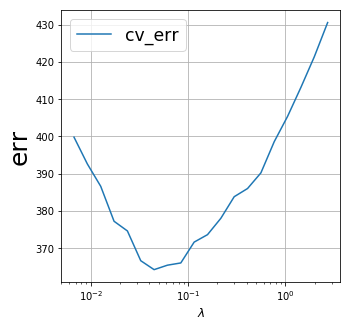

In [27]:
fg = plt.figure(figsize=(5, 5))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_linsvm, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")


In [28]:
C_opt_linsvm = C_arr[np.argmin(cv_err_linsvm)]
print C_opt_linsvm

0.0448127241853


### Re-train our model based on the $C_{opt}$

In [29]:
svm_linear = sksvm.LinearSVC(penalty="l2", dual=True, tol=1e-5, C=C_opt_linsvm, max_iter=10000)
svm_linear.fit(X[train, :], y[train])
y_test_pred_linsvm = svm_linear.predict(X[test, :])

In [30]:
print "False rate", np.sum(y[test] != y_test_pred_linsvm) / float(n_test)
print "False positive", np.sum(np.logical_and(y[test] == -1, y_test_pred_linsvm == 1)) / float(n_test_n)
print "False negative", np.sum(np.logical_and(y[test] == 1, y_test_pred_linsvm == -1)) / float(n_test_p)

False rate 0.0815015312493
False positive 0.0785009686913
False negative 0.131517317885


### 5-fold Cross Validation; L1 penalty

By using $L_1$ penalty, we want to solve the following optimization problem

$$ \text{minimize}\;\;\; \frac{1}{2}\|\beta\|_1 + C\sum_i \xi_i,\;\;\; \text{such that}\;\;\; y_i(\beta_0 + x_i^\top\beta) \geq 1 - \xi_i,\;\; \xi_i \geq 0,\;\; i = 1, \ldots, n .$$


In [31]:
# I tried a few rounds to decide a rough region for C_arr
# You can do something similar
C_arr_len = 20
C_arr = np.exp(np.linspace(-5, 1, C_arr_len))
cv_err_linsvm1 = np.empty(C_arr_len)
train_cv = np.copy(train)
for i in xrange(C_arr_len):
    print "tuning parameter: ", i
    svm_linear = sksvm.LinearSVC(penalty="l1", dual=False, tol=1e-5, C=C_arr[i], max_iter=1000)
    tmp_err = 0.0
    for j in xrange(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        svm_linear.fit(X[train_cv, :], y[train_cv])
        y_pred_k = svm_linear.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_linsvm1[i] = tmp_err / k

tuning parameter:  0
tuning parameter:  1
tuning parameter:  2
tuning parameter:  3
tuning parameter:  4
tuning parameter:  5
tuning parameter:  6
tuning parameter:  7
tuning parameter:  8
tuning parameter:  9
tuning parameter:  10
tuning parameter:  11
tuning parameter:  12
tuning parameter:  13
tuning parameter:  14
tuning parameter:  15
tuning parameter:  16
tuning parameter:  17
tuning parameter:  18
tuning parameter:  19


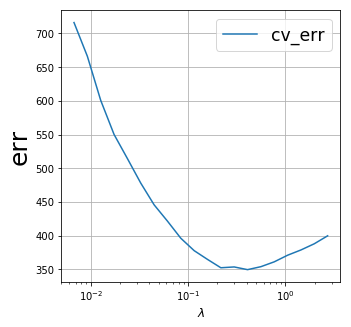

In [32]:
fg = plt.figure(figsize=(5, 5))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_linsvm1, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")


In [33]:
C_opt_linsvm1 = C_arr[np.argmin(cv_err_linsvm1)]
print C_opt_linsvm1

0.408715141106


### Re-train our model based on the $C_{opt}$

In [34]:
svm_linear = sksvm.LinearSVC(penalty="l1", dual=False, tol=1e-5, C=C_opt_linsvm1, max_iter=10000)
svm_linear.fit(X[train, :], y[train])
y_test_pred_linsvm1 = svm_linear.predict(X[test, :])

In [35]:
print "False rate", np.sum(y[test] != y_test_pred_linsvm1) / float(n_test)
print "False positive", np.sum(np.logical_and(y[test] == -1, y_test_pred_linsvm1 == 1)) / float(n_test_n)
print "False negative", np.sum(np.logical_and(y[test] == 1, y_test_pred_linsvm1 == -1)) / float(n_test_p)

False rate 0.0816061724347
False positive 0.0786932280344
False negative 0.130161469247


## Logistic Regression

In this part, we want to compare the performance of SVM and logistic regression. For SVM we use the Hinge loss, while for logistic regression we use the binomial deviance. The binomial deviance can be viewed as a smooth approximation to the Hinge loss.

### 5-fold Cross Validation, L2 penalty

In [36]:
# I tried a few rounds to decide a rough region for C_arr
# You can do something similar
C_arr_len = 20
C_arr = np.exp(np.linspace(-4, 2, C_arr_len))
cv_err_logi = np.empty(C_arr_len)
train_cv = np.copy(train)
for i in xrange(C_arr_len):
    print i
    logi = sklin.LogisticRegression(penalty="l2", tol=1e-5, C=C_arr[i], max_iter=1000)
    tmp_err = 0.0
    for j in xrange(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        logi.fit(X[train_cv, :], y[train_cv])
        y_pred_k = logi.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_logi[i] = tmp_err / k

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


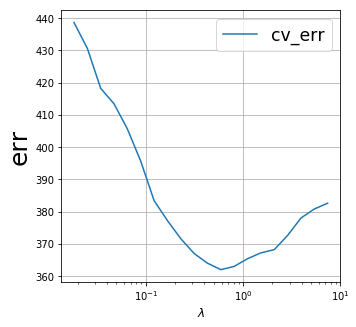

In [37]:
fg = plt.figure(figsize=(5, 5))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_logi, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")


In [38]:
C_opt_logi = C_arr[np.argmin(cv_err_logi)]
print C_opt_logi

0.590777513901


### Re-train our model based on the $C_{opt}$

In [39]:
logi = sklin.LogisticRegression(penalty="l2", tol=1e-5, C=C_opt_logi, max_iter=2000)
logi.fit(X[train, :], y[train])
y_test_pred_logi = logi.predict(X[test, :])

Below is the error I trained using the $C_{opt}$

In [40]:
print "False rate", np.sum(y[test] != y_test_pred_logi) / float(n_test)
print "False positive", np.sum(np.logical_and(y[test] == -1, y_test_pred_logi == 1)) / float(n_test_n)
print "False negative", np.sum(np.logical_and(y[test] == 1, y_test_pred_logi == -1)) / float(n_test_p)

False rate 0.0844175322818
False positive 0.0817915612938
False negative 0.128189325773


### 5-fold Cross Validation, penalty L1

In [41]:
# I tried a few rounds to decide a rough region for C_arr
# You can do something similar
C_arr_len = 20
C_arr = np.exp(np.linspace(-4, 2, C_arr_len))
cv_err_logi1 = np.empty(C_arr_len)
train_cv = np.copy(train)
for i in xrange(C_arr_len):
    print i
    logi = sklin.LogisticRegression(penalty="l1", tol=1e-5, C=C_arr[i], max_iter=1000)
    tmp_err = 0.0
    for j in xrange(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        logi.fit(X[train_cv, :], y[train_cv])
        y_pred_k = logi.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_logi1[i] = tmp_err / k

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


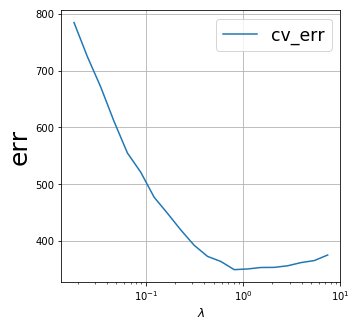

In [42]:
fg = plt.figure(figsize=(5, 5))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_logi1, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")


In [43]:
C_opt_logi1 = C_arr[np.argmin(cv_err_logi1)]
print C_opt_logi1

0.810157734932


### Re-train our model based on the $C_{opt}$

In [44]:
logi1 = sklin.LogisticRegression(penalty="l1", tol=1e-5, C=C_opt_logi1, max_iter=2000)
logi1.fit(X[train, :], y[train])
y_test_pred_logi1 = logi1.predict(X[test, :])

Below is the error I trained using the $C_{opt}$

In [45]:
print "False rate", np.sum(y[test] != y_test_pred_logi1) / float(n_test)
print "False positive", np.sum(np.logical_and(y[test] == -1, y_test_pred_logi1 == 1)) / float(n_test_n)
print "False negative", np.sum(np.logical_and(y[test] == 1, y_test_pred_logi1 == -1)) / float(n_test_p)

False rate 0.074448715355
False positive 0.0706257302158
False negative 0.138173302108


In [60]:
support_words = filtered_words[np.nonzero(logi.coef_[0] != 0)[0]]

In [64]:
print(support_words[:100])
print(support_words[-100:])

['talk' 'please' 'would' 'like' 'just' 'should' 'don' 'see' 'think'
 'people' 'edit' 'only' 'use' 'may' 'user' 'thanks' 'even' 'get' 'make'
 'good' 'had' 'well' 'very' 'could' 'deletion' 'help' 'new' 'source' 'go'
 'section' 'need' 'say' 'fuck' 'thank' 'made' 'discussion' 'deleted' 'same'
 'find' 'work' 'since' 'right' 'point' 'after' 'add' 'read' 'look' 'over'
 'someone' 'wiki' 'him' 'll' 'two' 'still' 'back' 'hi' 'too' 'list' 'link'
 'own' 'going' 'blocked' 'stop' 'content' 'without' 'block' 'history'
 'under' 'http' 'our' 'added' 'utc' 'editors' 'removed' 'her' 'might'
 'note' 'however' 'free' 'place' 'doesn' 'sure' 'case' 'done' 'us'
 'vandalism' 'she' 'reason' 'put' 'comment' 'let' 'personal' 'person'
 'better' 'yourself' 'using' 'seems' 'ask' 'actually' 'off']
['dis' 'rapist' 'snide' 'despicable' 'scumbag' 'hahahaha' 'tit' 'idiocy'
 'filth' 'homophobia' 'donate' 'jungle' 'worm' 'guests' 'weed' 'thug'
 'mama' 'bongwarrior' 'clowns' 'provocation' 'pedophiles' 'antics'
 'condensed' 

Linear methods performs more or less similar on the constructed datasets

## Kernel SVM
$$ \text{minimize}\;\;\; \frac{1}{2}\sum_{i, j} \alpha_i\alpha_j y_iy_j K(x_i, x_j) - \sum_i \alpha_i ,\;\;\; \text{such that}\;\;\; 0 \leq \alpha_i \leq C,\;\;\; i = 1, \ldots, n, \sum_i \alpha_i y_i = 0 $$;

$i$ such that $\alpha_i > 0$ are support vectors; $0 < \alpha_i < C$ stay on the boundary; $\alpha_i = C$ cross boundary;

Types of Kernel:
* linear: $K(x, x') = x^\top x'$
* RBF: $K(x, x') = \exp(-\gamma \|x - x'\|_2^2)$
* Polynomial: $K(x, x') = (\gamma x^\top x' + r)^d$
* Sigmoid: $K(x, x') = \tanh( \gamma x^\top x' + r)$


## Fitting kernel-SVM (RBF)

### 5-fold Cross Validation (slow, takes around 30 mins, please do not run during tutorial session)

In [ ]:
# I tried a few rounds to decide a rough region for C_arr
# You can do something similar
C_arr_len = 5
C_arr = np.exp(np.linspace(-4, 2, C_arr_len))
cv_err_svm_kern = np.empty(C_arr_len)
train_cv = np.copy(train)
for i in xrange(C_arr_len):
    print i
    svm_kern = sksvm.SVC(C=C_arr[i], kernel="rbf", gamma="auto", tol=1e-4, max_iter=-1)
    tmp_err = 0.0
    for j in xrange(k):
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = False
        svm_kern.fit(X[train_cv, :], y[train_cv])
        y_pred_k = svm_kern.predict(X[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        tmp_err += np.sum(y_pred_k != y[train_idx[cv_grid[j] : cv_grid[j + 1]]])
        train_cv[train_idx[cv_grid[j] : cv_grid[j + 1]]] = True
    cv_err_svm_kern[i] = tmp_err / k

0
1


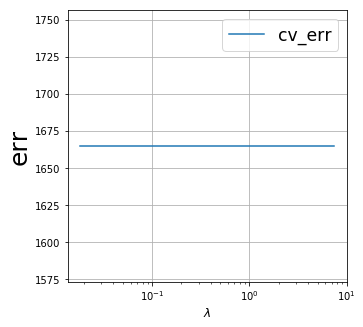

In [321]:
fg = plt.figure(figsize=(5, 5))
ax = fg.add_subplot(1, 1, 1)

ax.set_xlabel("$\lambda$", size="large")
ax.set_ylabel("err", size=25)
ax.set_xscale("log")

line_cv = ax.plot(C_arr, cv_err_svm_kern, label="cv_err")
ax.grid()

ax.legend(loc="best", fontsize="xx-large")


In [271]:
C_opt_kern = C_arr[np.argmin(cv_err_kern)]
print C_opt_kern

0.121813613837


### Re-train our model based on the $C_{opt}$

In [272]:
svm_kern = sksvm.SVC(C=C_arr[i], kernel="poly", gamma="auto", degree=3, tol=1e-4, max_iter=-1)
svm_kern.fit(X[train, :], y[train])
y_test_pred = svm_kern.predict(X[test, :])

Below is the error I trained using the $C_{opt}$

In [273]:
print "False positive", np.sum(np.logical_and(y[test] == -1, y_test_pred == 1)) / float(n_test_n)
print "True positive", np.sum(np.logical_and(y[test] == 1, y_test_pred == 1)) / float(n_test_p)
print "False negative", np.sum(np.logical_and(y[test] == 1, y_test_pred == -1)) / float(n_test_p)
print "True negative", np.sum(np.logical_and(y[test] == -1, y_test_pred == -1)) / float(n_test_n)

False positive 0.0136232167559
True positive 0.697943288305
False negative 0.302056711695
True negative 0.986376783244
